# IMPORT LIBRARIES

In [ ]:
import os
import numpy as np
import pandas as pd
import copy
import pickle
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data.dataset import Dataset

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score, adjusted_rand_score, confusion_matrix, f1_score, accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# CONNECT GOOGLE DRIVE (DATA DIRECTORY) TO GOOGLE COLAB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DATASET = 'REALSAT_TIMESERIES'
BASE_DIR = os.path.join("/content/drive/Shareddrives/Lake Meeting/")
INPUT_DIR = os.path.join(BASE_DIR, 'INPUT', DATASET)

YOUR_NAME = "Rahul" # Put your name here so that it creates your directory of outputs
YOUR_DIR = os.path.join(BASE_DIR, "OUTPUT", YOUR_NAME, DATASET)
NUMPY_DIR = os.path.join(YOUR_DIR, 'NUMPY')
MODEL_DIR = os.path.join(YOUR_DIR, 'MODEL')
RESULT_DIR = os.path.join(YOUR_DIR, 'RESULT')

if not os.path.exists(NUMPY_DIR):
    os.makedirs(NUMPY_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

The LSTM based deep learning algorithm used in this notebook provides a way to fill missing data and learn a low-dimensional feature space that can be used to cluster similar lakes together.

## HYPERPARAMETERS

In [ ]:
time_steps = 384
learning_rate = 0.001
train_percent = 0.8
val_percent = 0.2
n_epochs = 1000
n_clusters = 10
lim = 0
unknown = -999

device = torch.device("cuda")

batch_size = 100
channels = 1
code_dim = 64

## UTILITY FUNCTIONS

In [ ]:
def plot_total(array):
    plot_data = array.copy()
    plot_data[plot_data==unknown] = np.nan
    plt.figure(figsize=(40,2))
    ax = plt.subplot(1, 1, 1)
    x = np.array(range(len(plot_data)))
    ax.plot(x, plot_data)
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation="vertical")
    ax.set_ylim([np.nanmin(plot_data)-100, np.nanmax(plot_data)+100])
    plt.tight_layout(pad=0.0,h_pad=0.0,w_pad=0.0)
    plt.show()

def plot_monthly(array):
    plot_data = array.copy()

    months = 12
    plot_data = np.reshape(plot_data, (-1,12))
    years = plot_data.shape[0]
    months = plot_data.shape[1]
    plot_data[plot_data==unknown] = np.nan

    cols = 5
    rows = math.ceil(years/cols)
    plt.figure(figsize=(cols*2.5,rows*1))
    for row in range(rows):
        for col in range(cols):
            year = row*cols + col
            if year<years:
                ax = plt.subplot(rows, cols, row*cols+col+1)
                ax.set_title("Year:{}".format(year))
                x = np.array(range(months))
                ax.plot(x, plot_data[year])
                ax.set_xticks(x)
                ax.set_xticklabels(x, rotation="vertical")
                ax.set_ylim([np.nanmin(plot_data)-100, np.nanmax(plot_data)+100])
    plt.tight_layout(pad=0.0,h_pad=0.0,w_pad=0.0)
    plt.show()

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

def fill_nearby(array):
    array_nearby = array.copy()
    array_nearby[array_nearby==unknown] = np.nan
    nans, x= nan_helper(array_nearby)
    array_nearby[nans]= np.interp(x(nans), x(~nans), array_nearby[~nans])
    return array_nearby

def fill_monthly(array):
    array_monthly = array.copy()
    months = 12
    array_monthly = np.reshape(array_monthly, (-1,12))
    years = array_monthly.shape[0]
    months = array_monthly.shape[1]
    array_monthly[array_monthly==unknown] = np.nan
    for month in range(months):
        nans, x= nan_helper(array_monthly[:,month])
        try:
            array_monthly[:,month][nans]= np.interp(x(nans), x(~nans), array_monthly[:,month][~nans])
        except:
            pass
    array_monthly = np.reshape(array_monthly, -1)
    return array_monthly

# LOADING DATA

## READ DATA

In [ ]:
print("#######################################################################")
print("LOAD DATA")
X = np.load(os.path.join(INPUT_DIR, "X_subset_v2.npy"), allow_pickle = True).astype(np.float32)
X[X==-1] = unknown
print(X.shape)
print(np.max(X), np.min(X))

#######################################################################
LOAD DATA
(4000, 384)
85801.0 -999.0


## INTERPOLATE MISSING DATA

In [ ]:
X_fill = X.copy()
for i,lake in enumerate(X_fill):
    # plot_total(lake)
    # plot_monthly(lake)
    """fill nearby"""
    lake_nearby = fill_nearby(lake)
    # plot_total(lake_nearby)
    # plot_monthly(lake_nearby)
    """fill monthly"""
    lake_monthly = fill_monthly(lake)
    # plot_total(lake_monthly)
    # plot_monthly(lake_monthly)
    """fill avg of monthly and nearby"""
    lake_avg = np.stack([lake_monthly, lake_nearby], axis=0)
    lake_avg = np.nanmean(lake_avg, axis=0)
    # plot_total(lake_avg)
    # plot_monthly(lake_avg)
    """replace back"""    
    X_fill[i] = lake_nearby # interpolating from the nearby time-steps as per slack discussion
    # break
print(X_fill.shape)
print(np.max(X_fill), np.min(X_fill))

(4000, 384)
85801.0 0.0


#######################################################################
PREPROCESS INPUTS
11.30456 -999.0
11.30456 -12.447284


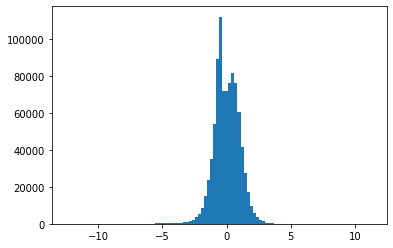

#######################################################################
DATA SPLIT
(3200, 384, 1) (3200, 384, 1)
(800, 384, 1) (800, 384, 1)
(0, 384, 1) (0, 384, 1)
#######################################################################
DATA LOADER
Train batch:4	Val batch:1


In [ ]:
print("#######################################################################")
print("PREPROCESS INPUTS")
X_unknown = X.copy()
X_unknown[X==unknown] = np.nan
mean = np.reshape(np.nanmean(X_unknown, axis=1), (-1,1))
std = np.reshape(np.nanstd(X_unknown, axis=1), (-1,1))
X = (X - mean)/std
X[np.isnan(X_unknown)] = unknown
print(np.max(X), np.min(X))
X_fill = (X_fill - mean)/std
print(np.max(X_fill), np.min(X_fill))

plt.hist(X[X!=unknown].flatten(), bins=100)
plt.show()

print("#######################################################################")
print("DATA SPLIT")
num_samples = X.shape[0]
train_samples = int(train_percent*num_samples)
val_samples = int(val_percent*num_samples)

train_X = X_fill[:train_samples]
train_X = np.expand_dims(train_X, axis=2)
train_Y = X[:train_samples]
train_Y = np.expand_dims(train_Y, axis=2)

val_X = X_fill[train_samples:train_samples+val_samples]
val_X = np.expand_dims(val_X, axis=2)
val_Y = X[train_samples:train_samples+val_samples]
val_Y = np.expand_dims(val_Y, axis=2)

test_X = X_fill[train_samples+val_samples:]
test_X = np.expand_dims(test_X, axis=2)
test_Y = X[train_samples+val_samples:]
test_Y = np.expand_dims(test_Y, axis=2)

print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)
print(test_X.shape, test_Y.shape)

print("#######################################################################")
print("DATA LOADER")
class loader(Dataset):

    def __init__(self, X, y):
        self.data = X
        self.labels = y


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

train_data = loader(X=train_X, y=train_Y)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_data = loader(X=val_X, y=val_Y)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_data = loader(X=test_X, y=test_Y)
# test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=0)
print("Train batch:{}\tVal batch:{}".format(len(train_loader), len(val_loader)))

# DEFINE MODEL

In [ ]:
print("#######################################################################")
print("DEFINE MODEL")
class BiRNN(torch.nn.Module):
    def __init__(self, in_channels, code_dim):
        super(BiRNN,self).__init__()

        self.encoder = torch.nn.GRU(in_channels, code_dim, batch_first=True, bidirectional=True)
        self.decoder = torch.nn.GRU(in_channels, code_dim, batch_first=True)
        self.out = torch.nn.Linear(code_dim, in_channels)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
    
    def forward(self, x):
        batch_size, seq_len, in_channels = x.shape
        
        _, code_vec = self.encoder(x)
        code_vec = torch.unsqueeze(torch.sum(code_vec, dim=0), dim=0)
        
        out = torch.zeros(batch_size, seq_len, in_channels).to(device)
        h = code_vec
        input = torch.zeros((batch_size, 1, in_channels)).to(device)
        for step in range(seq_len):
            input, h = self.decoder(input, h)
            output = self.out(input.squeeze())
            out[:,step] = output
            input = output.unsqueeze(1)
        return code_vec.squeeze(), out

print("#######################################################################")
print("BUILD MODEL")
model = BiRNN(in_channels=channels, code_dim=code_dim)
model = model.to('cuda')
criterion = torch.nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

data = torch.randn(batch_size, time_steps, channels)
code_vec, out = model(data.to('cuda'))
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Data:{}\tCode:{}\tRecon:{}\tParameters:{}".format(data.shape, code_vec.shape, out.shape, pytorch_total_params))

#######################################################################
DEFINE MODEL
#######################################################################
BUILD MODEL
Data:torch.Size([1000, 384, 1])	Code:torch.Size([1000, 32])	Recon:torch.Size([1000, 384, 1])	Parameters:10113


# TRAIN MODEL

## TRAIN AUTOENCODER

In [ ]:
print("#######################################################################")
print("TRAIN MODEL")
train_loss = []
val_loss = []
min_loss = 100
for epoch in range(1,n_epochs):

    model.train()

    total_loss = 0
    for batch, [data, labels] in enumerate(train_loader):
        optimizer.zero_grad()

        code, out = model(data.to('cuda'))
        loss = criterion(torch.squeeze(out), torch.squeeze(labels.to('cuda')))
        loss = torch.masked_select(loss, (torch.squeeze(labels)!=unknown).to('cuda'))
        loss = torch.mean(loss)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('Epoch:{}\tTrain Loss:{}'.format(epoch, total_loss/(batch+1)), end="\t")
    train_loss.append(total_loss/(batch+1))

    total_loss = 0
    for batch, [data, labels] in enumerate(val_loader):
        code, out = model(data.to('cuda'))
        loss = criterion(torch.squeeze(out), torch.squeeze(labels.to('cuda')))
        loss = torch.masked_select(loss, (torch.squeeze(labels)!=unknown).to('cuda'))
        loss = torch.mean(loss)
        total_loss += loss.item()
    print('Val Loss:{}\tMin Loss:{}'.format(total_loss/(batch+1), min_loss))
    val_loss.append(total_loss/(batch+1))
    if min_loss>val_loss[-1]:
        min_loss = val_loss[-1]
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "AE.pt"))

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
ax.plot(train_loss, label='train')
ax.plot(val_loss, label='val')
ax.legend()
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
plt.savefig(os.path.join(RESULT_DIR, "AE.pdf"), format = "pdf")
plt.show()

#######################################################################
TRAIN MODEL
Epoch:1	Train Loss:1.0054304599761963	Val Loss:1.0079264640808105	Min Loss:100
Epoch:2	Train Loss:1.0039807856082916	Val Loss:0.9994900822639465	Min Loss:1.0079264640808105
Epoch:3	Train Loss:1.0006682127714157	Val Loss:1.0003305673599243	Min Loss:0.9994900822639465
Epoch:4	Train Loss:0.9972162246704102	Val Loss:0.9954767227172852	Min Loss:0.9994900822639465
Epoch:5	Train Loss:0.991242527961731	Val Loss:0.9924207925796509	Min Loss:0.9954767227172852
Epoch:6	Train Loss:0.9844256192445755	Val Loss:0.9853599071502686	Min Loss:0.9924207925796509
Epoch:7	Train Loss:0.9724995791912079	Val Loss:0.9831600189208984	Min Loss:0.9853599071502686
Epoch:8	Train Loss:0.9526197612285614	Val Loss:0.9726490378379822	Min Loss:0.9831600189208984
Epoch:9	Train Loss:0.9267035275697708	Val Loss:0.9779914617538452	Min Loss:0.9726490378379822
Epoch:10	Train Loss:0.9320218414068222	Val Loss:0.9782828092575073	Min Loss:0.97264903